# Case 1. Heart Disease Classification

#### Joonas Lehikoinen, Przemyslaw Zuchmanski
##### 31.01.2020
### Helsinki Metropolia University of Applied Sciences

The main object is to created and train a dense neural network to predict the presence of heart disease on the base of heart disease cleveland data downloaded from the site: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ .<br><br><br><br>

## Data
The data contains values of various health factors usefull in detecting heart diseases. There are 13 factors described in 13 coluns. 14th column describes if the patint sufers from heart disease. The number of records is 303. Missing values (detected in 6 raws) were replaced with 0. 

In [1]:
%pylab inline
import pandas as pd
import numpy
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split


#names of columns
names = ["age","sex","cp","trestbps","chol","fbs","restecg",
                            "thalach","examg","oldpeak","slope","ca","thal","num"]
                   
#reading data and giving names for columns, detecting NaN valuess
df = pd.read_csv("processed.cleveland.data", 
                 names=names,
                     header=None, 
                     index_col = None, 
                     na_values = '?')

#replacing NaN values with 0
df = df.replace(numpy.NaN,0)

Populating the interactive namespace from numpy and matplotlib


Basic statistics are as follows

In [2]:
print('shape of data set: ', df.shape)
df.describe()

shape of data set:  (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,examg,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.702970,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.971038,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Division data into two subsets: <br>
data - all health factors <br>
labels - indicate if the person is rather sick (1) or healthy (0)

In [3]:
#dividing set to data and labels
data = df.drop(['num'], axis=1)
#converting labels to binary atribute
label = 1.0*(df['num'] >0)

## Models and training
Dividing data. For training and validating we use 80% of samples. Remains 20% we will use for testing.

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(
                    data,
                    label,
                    test_size = 0.2,
                    random_state = 39,
                    shuffle = True)

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std


### Functions
in order to makes testing and showing the resuts easier we made functions

###### defineModel
Defining a the model. We use 20% of remaining data for validation. <br>
Function is build in such a way that it enables changes the main parameters such as number of layers, size of layers, activation list, regulizer, number of dropouts and optimizer when calling. <br>
Funcion also prints setup for easier testing.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import np_utils
from tensorflow.keras import regularizers

model=None
history = model

def defineModel(layers_num,neurons_list,activation_list,regualizer_list,dropout_num,optimizer_str):
    
    #Define use of global model parameter 
    global model
    model=None
    model = Sequential()
    
    #Define parameters
    LSTM_layer_num=3
    layer_size = neurons_list    
    activation_list=activation_list #softmax, tanh, sigmoid, linear    
    dropout=dropout_num
    model = Sequential()
    regularizer_list = regualizer_list
    
    #Compile parameters
    optimizer_par= optimizer_str #"adam", RMSprop
    metrics_par = "accuracy"
    loss_par="binary_crossentropy"
    

    # Define layers and parameters, printing for easier testing 
    
    print('''
        ********** NEURAL NETWORK STRUCTURE **********''')
    model.add(Dense(layer_size[0],name="input", input_shape =(13,),activation=activation_list[0],kernel_regularizer=regularizers.l2(regularizer_list[0])))
    model.add(Dropout(dropout))
    print(f'''
        Layer1 - neurons: {layer_size[0]}, activation: {activation_list[0]}, regularizer: L2({regularizer_list[0]})
        Dropout - {dropout}''')
    
    
    if (layers_num>=2):
        model.add(Dense(layer_size[1],name="dense1", activation=activation_list[1],kernel_regularizer=regularizers.l2(regularizer_list[1])))
        model.add(Dropout(dropout))
        print(f'''
        Layer2 - neurons: {layer_size[1]}, activation: {activation_list[1]}, regularizer: L2({regularizer_list[1]})
        Dropout - {dropout}''')
        
        if (layers_num==3):
            
            model.add(Dense(layer_size[2],name="dense2", activation=activation_list[2],kernel_regularizer=regularizers.l2(regularizer_list[2])))
            model.add(Dropout(dropout))
            print(f'''
        Layer3 - neurons: {layer_size[1]}, activation: {activation_list[2]}, regularizer: L2({regularizer_list[2]})
        Dropout - {dropout})''')
    
    model.add(Dense(1,activation = "sigmoid",name="output"))
    
    #Compile model
    model.compile(loss = loss_par, optimizer = optimizer_par, metrics=[metrics_par])
          
          
    print(f'''
        Dense(output) - neurons: 1, activation: sigmoid)\n
        Optimizer: {optimizer_par}''')
    #print models layer information
    #model.summary()  

#### fitModel
Fitting model and storing data for testing.<br> 
Function is build in such a way that it enables changes the main parameters such as num of epochs and batch size.<br>
Each time the function is called check point with loss is saved in external file.

In [6]:
def fitModel(num_epo,batch):
    global model
    
    print(f'''
        Batch-size: {batch}
        epochs: {num_epo})
    ''')
    
    #Define callbacks and checkpoint (saves best model out of epochs based on monitored alue)
    checkpoint_name = 'DiseaseModel'
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 0, save_best_only = True, mode ='min')#,patience=3
    callbacks_list = [checkpoint]  
    
      
    
    #Define parameters and Fit the model :
    global history
    model_params = {'epochs': num_epo,
                    'batch_size': batch,
                    'callbacks': callbacks_list,
                    'verbose': 0,
                    'validation_split': 0.20,
                    'shuffle': True,
                    'initial_epoch': 1,
                    'steps_per_epoch': None,
                    'validation_steps': None}

    
    history=model.fit(train_data.values,
    train_labels.values,
    epochs = model_params['epochs'],
    batch_size = model_params['batch_size'],
    callbacks= model_params['callbacks'],
    verbose = model_params['verbose'],
    validation_split = model_params['validation_split'],   
                     )

#### plot
Plotting loss and accuracy vs time presented in epochs

In [7]:
def plot():
    # Plot the loss score and mean absolute error for both training and validation setss
    

    #collecting data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['acc']
    val_mae = history.history['val_acc']
    
    #Cut first points of graph
    short_loss = loss[2:]
    short_val_loss = val_loss[2:]
    

    #defining time axis
    time = range(1,len(loss)+1)

    #ploting loss vs Epochs
    #loss of validation set is red
    plt.plot(range(1,len(short_loss)+1), short_loss, 'b-')
    #plt.plot(time, loss, 'b-')
    plt.plot(range(1,len(short_val_loss)+1), short_val_loss, 'r-')
    #plt.plot(time, val_loss, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    #ploting accuracy vs Epochs
    #accuracy of validation set is red
    
    #plt.plot(range(1,len(short_loss)+1), short_mae, 'b-')
    plt.plot(time, mae, 'b-')
    #plt.plot(range(1,len(short_val_loss)+1), short_val_mae, 'r-')
    plt.plot(time, val_mae, 'r-')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.show()

#### evaluate
Evaluate model and print results. Additionally the function returs the uotput of evaluation

In [8]:
def evaluate():
    score = model.evaluate(test_data.values, test_labels.values)
    
    print(f'''\n
*************  TEST RESULT  ******************
    \nLoss: {score[0]}\nAccuracy: {score[1]*100}\n
***********************************************''')
    
    #return score

#### loadWeights
Load previously saved model from computer

In [9]:
def loadWeights(weightFile):
    weights_file = weightFile # weights file path
    model.load_weights(weights_file)
    model.compile(loss = 'mse', optimizer = 'adam',metrics=['mae'])

## Results

##### Main tried combinations
Different kind of neural networks were tried on data sets and here is some findings from different models.
Parameters for each network can be found above graphs.



### 13 neurons 1-3 layers.

1 Layer: model seemed to perform quite well till ~40-50 epochs with training and validaiting set.
Testing set proofed this claim to be true. 


##### Test results:

40 epochs:
    
Loss: 0.3444248721247814
Accuracy: 91.80327653884888



2 layers:
most of the time performed well till 120~epochs after that slight over fitting could be noticed.



        ********** NEURAL NETWORK STRUCTURE **********

        Layer1 - neurons: 13, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1

        Dense(output) - neurons: 1, activation: sigmoid)

        Optimizer: adam

        Batch-size: 4
        epochs: 40)
    


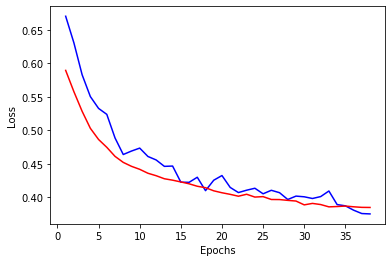

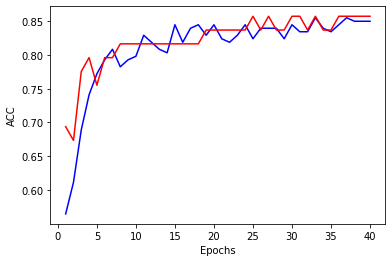

61/61 [==============================] - 0s 81us/sample - loss: 0.3611 - acc: 0.8852


*************  TEST RESULT  ******************
    
Loss: 0.36109327097408106
Accuracy: 88.52459192276001

***********************************************


In [31]:
#makeModel(layers_num, neurons_list[num], activation_list[str], regualzer_list[num], dropout_num, optimizer_str)
defineModel(1,[13],["relu"],[0.005],0.1,"adam")

#fitModel(epochs_num,batch_num)
fitModel(40,4)
plot()

#Evaluate
evaluate()


        ********** NEURAL NETWORK STRUCTURE **********

        Layer1 - neurons: 13, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1

        Layer2 - neurons: 13, activation: relu, regularizer: L2(0.05)
        Dropout - 0.1

        Dense(output) - neurons: 1, activation: sigmoid)

        Optimizer: adam

        Batch-size: 4
        epochs: 120)
    


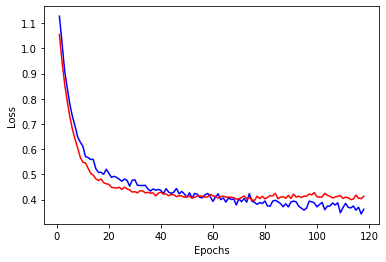

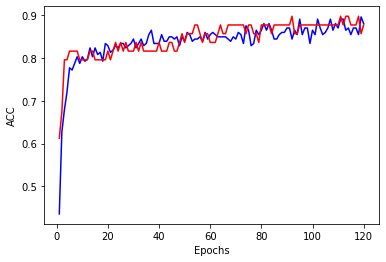

61/61 [==============================] - 0s 49us/sample - loss: 0.3802 - acc: 0.9016


*************  TEST RESULT  ******************
    
Loss: 0.38018937579921036
Accuracy: 90.16393423080444

***********************************************


In [29]:
#makeModel(layers_num, neurons_list[num], activation_list[str], regualzer_list[num], dropout_num, optimizer_str)
defineModel(2,[13,13],["relu","relu"],[0.005,0.05],0.1,"adam")

#fitModel(epochs_num,batch_num)
fitModel(120,4)
plot()

#Evaluate
evaluate()


        ********** NEURAL NETWORK STRUCTURE **********

        Layer1 - neurons: 13, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1

        Layer2 - neurons: 13, activation: relu, regularizer: L2(0.05)
        Dropout - 0.1

        Layer3 - neurons: 13, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1)

        Dense(output) - neurons: 1, activation: sigmoid)

        Optimizer: adam

        Batch-size: 4
        epochs: 150)
    


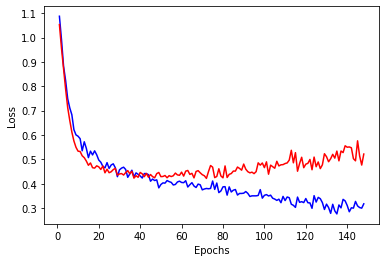

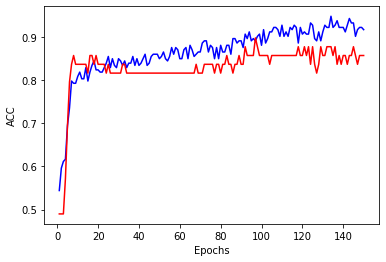

61/61 [==============================] - 0s 98us/sample - loss: 0.5307 - acc: 0.8525


*************  TEST RESULT  ******************
    
Loss: 0.5307473510992332
Accuracy: 85.24590134620667

***********************************************


In [34]:
#makeModel(layers_num, neurons_list[num], activation_list[str], regualzer_list[num], dropout_num, optimizer_str)
defineModel(3,[13,13,13],["relu","relu","relu"],[0.005,0.05,0.005],0.1,"adam")

#fitModel(epochs_num,batch_num)
fitModel(150,4)
plot()

#Evaluate
evaluate()

### 400 neurons 1 layer:

When we used 400 neurons on each layers:

1 layer model: seemed to performed very poorly when we looked on graph. It started to overfit after 15 epochs so we tried to finetune the model by dropping the epochs to 15. Results were quite suprising because now model performed better than any model before on testing set.

150 epochs:
Loss: 0.5629275245744674
Accuracy: 78.68852615356445

15 epochs:
Loss: 0.37276301374200915
Accuracy: 93.44262480735779



        ********** NEURAL NETWORK STRUCTURE **********

        Layer1 - neurons: 400, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1

        Dense(output) - neurons: 1, activation: sigmoid)

        Optimizer: adam

        Batch-size: 4
        epochs: 100)
    


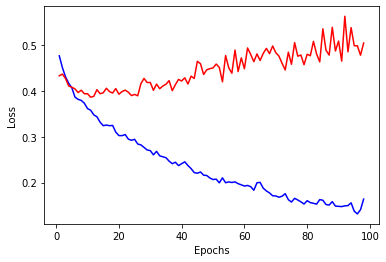

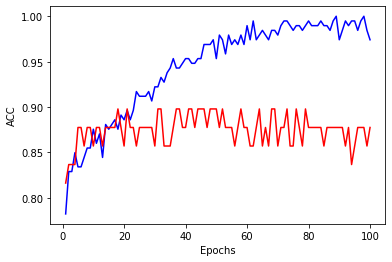

61/61 [==============================] - 0s 147us/sample - loss: 0.5622 - acc: 0.7705


*************  TEST RESULT  ******************
    
Loss: 0.5622253212772432
Accuracy: 77.04917788505554

***********************************************


In [13]:
#makeModel(layers_num, neurons_list[num], activation_list[str], regualzer_list[num], dropout_num, optimizer_str)
defineModel(1,[400],["relu"],[0.005],0.1,"adam")

#fitModel(epochs_num,batch_num)
fitModel(100,4)
plot()

#Evaluate
evaluate()


        ********** NEURAL NETWORK STRUCTURE **********

        Layer1 - neurons: 400, activation: relu, regularizer: L2(0.005)
        Dropout - 0.1

        Dense(output) - neurons: 1, activation: sigmoid)

        Optimizer: adam

        Batch-size: 4
        epochs: 15)
    


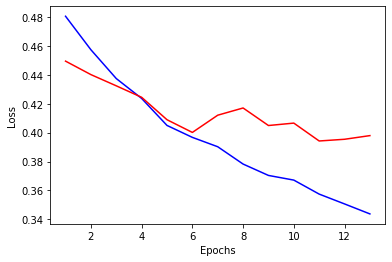

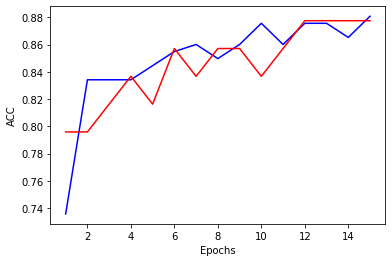

61/61 [==============================] - 0s 98us/sample - loss: 0.3668 - acc: 0.9180


*************  TEST RESULT  ******************
    
Loss: 0.36678795589775337
Accuracy: 91.80327653884888

***********************************************


In [35]:
#makeModel(layers_num, neurons_list[num], activation_list[str], regualzer_list[num], dropout_num, optimizer_str)
defineModel(1,[400],["relu"],[0.005],0.1,"adam")

#fitModel(epochs_num,batch_num)
fitModel(15,4)
plot()

#Evaluate
evaluate()

#### Additional results with different parameter:

## 1:    
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense2 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer:adam
    
    Batch-size: 10
    epochs: 250
    ***********************************************************************************  
    
    Result:
    
    Loss: 0.42949211988292757
    Accuracy: 91.80327653884888


## 2:    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense2 - neurons: 68, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer:adam
    
    Batch-size:4
    epochs: 250
    ***********************************************************************************
    
    Result:

    Loss: 0.3861997435327436
    Accuracy: 91.80327653884888

## 3:
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 115
    ***********************************************************************************
    
    
    TEST RESULT:
    
    Loss: 0.40598516874626034
    Accuracy: 86.8852436542511

    ***********************************************
    

## 4:
    
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 65
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.406089111429746
    Accuracy: 90.16393423080444

    ***********************************************

## 5:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 84, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 84, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 10
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.5175350904464722
    Accuracy: 90.16393423080444

    ***********************************************

## 6:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 16, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 150
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.39709243178367615
    Accuracy: 90.16393423080444

    ***********************************************

## 7:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.2

    Dense2 - neurons: 16, activation: relu, regularizer: L2(0.1)

    Dropout - 0.2

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 200
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3838785530113783
    Accuracy: 90.16393423080444
    
    ***********************************************

## 8:
    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 16, activation: relu, regularizer: L2(0.05)

    Dropout - 0.4

    Dense2 - neurons: 8, activation: relu, regularizer: L2(0.1)

    Dropout - 0.4

    Dense(output) - neurons: 1, activation: sigmoint)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 500
    ***********************************************************************************
    
    *************  TEST RESULT  ******************

    Loss: 0.39709243178367615
    Accuracy: 90.16393423080444

    ***********************************************

## 9:

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2

    Dense2 - neurons: 5, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2
    
    Dense2 - neurons: 5, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2


    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 100
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3525885934712457
    Accuracy: 85.24590134620667

    ***********************************************

## 10

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.2

    Dense2 - neurons: 13, activation: relu, regularizer: L2(0.05)

    Dropout - 0.2

    Dense(output) - neurons: 1)
    
    Optimizer: adam
    
    Batch-size: 4
    epochs: 150
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.3697339247484676
    Accuracy: 88.52459192276001

    ***********************************************

## 11

    ***********************************************************************************
    Layers: 
 
    Dense1 - neurons: 13, activation: relu, regularizer: L2(0.005)

    Dropout - 0.1

    Dense2 - neurons: 9, activation: relu, regularizer: L2(0.005)

    Dropout - 0.1

    Dense(output) - neurons: 1, activation: sigmoid)
    
    Optimizer: adam
    
    Batch-size: 2
    epochs: 50
    ***********************************************************************************
    
    *************  TEST RESULT  ******************
    
    Loss: 0.35020713337132187
    Accuracy: 90.16393423080444

    ***********************************************